# Bozzo Francesco - NLU Exam

This Jupyter notebook contains the code for the February session of Natural Language Understanding course.

The notebook uses some pieces of code already given by the lecturers during LAB 10.

# Sequence Labelling and Text classification tasks

### Sequence Labelling
The sequence labelling task is defined as:
- Given a sequence of tokens $w = {w_1, w_2, ..., w_n}$,
- defining a sequence of labels as $l = {l_1, l_2, ..., l_n}$
- compute the sequence $\hat{l}$ such as $\hat{l} = \underset{l}{\operatorname{argmax}} P(l|w)$ 

In this lab session, we are going to see a particular case of sequence labelling task, which is named as Slot Filling (or Concept tagging). In this notebook, the **segmentation** (with IOB tags) and the **labelling** are done at the same time. \
\
An example is the following: 

| Slot Filling |  |                     |                     |  |  |  |  |
|------------------|----|--------------------------|--------------------------|---|------|---|--------|
| Input sequence:  | on | april                    | first                    | I | want | a | flight |
| Output sequence: | O  | B-depart_date.month_name | B-depart_date.day_number | O | O    | O | O      |

### Text classification
The text classification problem is defined *(similar to Sequence Labelling)* as follows:
- Given a sequence of tokens $w = {w_1, w_2, ..., w_n}$,
- And a set of labels $L$ where $l \in L$
- estimate the label $\hat{l}$ such as $\hat{l} = \underset{l}{\operatorname{argmax}} P(l|w)$ 

The text classification task that we are going to see in this laboratory is named as Intent Classification. The Intent is an additional component of the *semantic frame*. \
\
An example is the following:

| Intent Classification|  |                     |                     |  |  |  |  |
|------------------|----|--------------------------|--------------------------|---|------|---|--------|
| Input sequence:  | on | april                    | first                    | I | want | a | flight |
| Output label: | flight     |


# Dataset
This different dataset are used in this notebook to validate the goodness of the obtained results:
- ATIS (Airline Travel Information Systems). It is composed of trascriptions of humans asking about flight information.
- SNIPS which contains over 16,000 crowdsourced queries distributed among 7 user intents of various complexity.

## Structure

```json
[
    {
    "utterance": "on april first i need a flight going from phoenix to san diego", 
    "slots": "O B-depart_date.month_name B-depart_date.day_number O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name", 
    "intent": "flight"
    },
    "..."
]
```

In [1]:
# Global variables
import os
device = "cuda:0" # cuda:0 means we are using the GPU with id 0, if you have multiple GPU
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" # Used to report errors on CUDA side
PAD_TOKEN = 0

In [2]:
import json
from pprint import pprint

# load training and test dataset for both ATIS and SNIPS

def load_data(path: str) -> list[dict]:
    """
    input: path/to/data
    output: json 
    """
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset

tmp_train_raw_atis = load_data(os.path.join("data", "ATIS", "train.json"))
test_raw_atis = load_data(os.path.join("data", "ATIS", "test.json"))

train_raw_snips = load_data(os.path.join("data", "SNIPS", "train.json"))
dev_raw_snips = load_data(os.path.join("data", "SNIPS", "valid.json"))
test_raw_snips = load_data(os.path.join("data", "SNIPS", "test.json"))

print("ATIS Train samples:", len(tmp_train_raw_atis))
print("ATIS Test samples:", len(test_raw_atis))

print("SNIPS Train samples:", len(train_raw_snips))
print("SNIPS Dev samples:", len(dev_raw_snips))
print("SNIPS Test samples:", len(test_raw_snips))

ATIS Train samples: 4978
ATIS Test samples: 893
SNIPS Train samples: 13084
SNIPS Dev samples: 700
SNIPS Test samples: 700


### Create a dev set for ATIS
In the original split the developement set (dev set) is missing. To train and find the best hyperparameter of our network the dev set is fundamental. Thus, we have to create it starting from the **traning** set. The dev set is usually the 10% of the dataset. \
Possible sampling strategies:
* Take the last n elements of the training set.
* Do a random sampling from the training set.
* Do a stratified sampling from the training set using one or more criteria. (The best way)
    * For further details look [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

# Firt we get the 10% of dataset, then we compute the percentage of these examples 
# on the training set which is around 11% 
portion = round(((len(tmp_train_raw_atis) + len(test_raw_atis)) * 0.10)/(len(tmp_train_raw_atis)), 2)

# We stratify on intents
intents = [x['intent'] for x in tmp_train_raw_atis] 
count_y = Counter(intents)

Y = []
X = []
mini_Train = []

for id_y, y in enumerate(intents):
    if count_y[y] > 1: # Some intents have only one instance, we put them in training
        X.append(tmp_train_raw_atis[id_y])
        Y.append(y)
    else:
        mini_Train.append(tmp_train_raw_atis[id_y])
# Random Stratify
X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=portion, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=Y)
X_train.extend(mini_Train)
train_raw_atis = X_train
dev_raw_atis = X_dev

y_test = [x['intent'] for x in test_raw_atis]

# Intent distribution
print('Train:')
pprint({k:round(v/len(y_train),3)*100 for k, v in sorted(Counter(y_train).items())})
print('Dev:'), 
pprint({k:round(v/len(y_dev),3)*100 for k, v in sorted(Counter(y_dev).items())})
print('Test:') 
pprint({k:round(v/len(y_test),3)*100 for k, v in sorted(Counter(y_test).items())})
print('='*89)

# Dataset size
print('ATIS TRAIN size:', len(train_raw_atis))
print('ATIS DEV size:', len(dev_raw_atis))
print('ATIS TEST size:', len(test_raw_atis))

Train:
{'abbreviation': 2.9000000000000004,
 'aircraft': 1.6,
 'airfare': 8.5,
 'airline': 3.2,
 'airline+flight_no': 0.0,
 'airport': 0.4,
 'capacity': 0.3,
 'city': 0.4,
 'distance': 0.4,
 'flight': 73.7,
 'flight+airfare': 0.4,
 'flight_no': 0.3,
 'flight_time': 1.0999999999999999,
 'ground_fare': 0.4,
 'ground_service': 5.1,
 'meal': 0.1,
 'quantity': 1.0,
 'restriction': 0.1}
Dev:
{'abbreviation': 3.0,
 'aircraft': 1.7000000000000002,
 'airfare': 8.5,
 'airline': 3.2,
 'airport': 0.3,
 'capacity': 0.3,
 'city': 0.3,
 'distance': 0.3,
 'flight': 73.7,
 'flight+airfare': 0.5,
 'flight_no': 0.2,
 'flight_time': 1.0,
 'ground_fare': 0.3,
 'ground_service': 5.2,
 'meal': 0.2,
 'quantity': 1.0,
 'restriction': 0.2}
Test:
{'abbreviation': 3.6999999999999997,
 'aircraft': 1.0,
 'airfare': 5.4,
 'airfare+flight': 0.1,
 'airline': 4.3,
 'airport': 2.0,
 'capacity': 2.4,
 'city': 0.7000000000000001,
 'day_name': 0.2,
 'distance': 1.0999999999999999,
 'flight': 70.8,
 'flight+airfare': 1.3,
 

### Lang class
This is a helper class to convert words, slots, and intents to progressive identifiers and vice versa.

In [4]:
from collections import Counter

class Lang:
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}
        
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'[PAD]': PAD_TOKEN}
        if unk:
            vocab['[UNK]'] = len(vocab)
        count = Counter(sorted(elements))
        for k, v in count.items():
            if v > cutoff:
                vocab[k] = len(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in sorted(elements):
                vocab[elem] = len(vocab)
        return vocab

In [5]:
words_atis = sum([x['utterance'].split() for x in train_raw_atis], []) # No set() since we want to compute the cutoff
corpus_atis = train_raw_atis + dev_raw_atis + test_raw_atis # We do not want unk labels
slots_atis = set(sum([line['slots'].split() for line in corpus_atis],[]))
intents_atis = set([line['intent'] for line in corpus_atis])

lang_atis = Lang(words_atis, intents_atis, slots_atis, cutoff=0)

In [6]:
words_snips = sum([x['utterance'].split() for x in train_raw_snips], []) # No set() since we want to compute the cutoff
corpus_snips = train_raw_snips + dev_raw_snips + test_raw_snips # We do not want unk labels
slots_snips = set(sum([line['slots'].split() for line in corpus_snips],[]))
intents_snips = set([line['intent'] for line in corpus_snips])

lang_snips = Lang(words_snips, intents_snips, slots_snips, cutoff=0)

In [7]:
print("ATIS - unique words:", len(lang_atis.word2id))
print("ATIS - unique slots:", len(lang_atis.slot2id))
print("ATIS - unique intents:", len(lang_atis.intent2id))

print("SNIPS - unique words:", len(lang_snips.word2id))
print("SNIPS - unique slots:", len(lang_snips.slot2id))
print("SNIPS - unique intents:", len(lang_snips.intent2id))

ATIS - unique words: 863
ATIS - unique slots: 130
ATIS - unique intents: 26
SNIPS - unique words: 11420
SNIPS - unique slots: 73
SNIPS - unique intents: 7


In [8]:
from collections import Counter

slot_list_atis = [line['slots'].split() for line in corpus_atis]
slot_flat_list_atis = [item for sublist in slot_list_atis for item in sublist]
print("ATIS - total slots:", len(slot_flat_list_atis))

intent_list_atis = [line['intent'].split()[0] for line in corpus_atis]
print("ATIS - total intents:", len(intent_list_atis))

slot_counter_atis = Counter(slot_flat_list_atis)
intent_counter_atis = Counter(intent_list_atis)

ATIS - total slots: 65789
ATIS - total intents: 5871


In [9]:
set(sum([line['intent'].split() for line in test_raw_atis],[])).difference(
    sum([line['intent'].split() for line in train_raw_atis],[])
)

{'airfare+flight', 'day_name', 'flight+airline', 'flight_no+airline'}

In [10]:
from collections import Counter

slot_list_snips = [line['slots'].split() for line in corpus_snips]
slot_flat_list_snips = [item for sublist in slot_list_snips for item in sublist]
print("SNIPS - total slots:", len(slot_flat_list_snips))

intent_list_snips = [line['intent'].split()[0] for line in corpus_snips]
print("SNIPS - total intents:", len(intent_list_snips))

slot_counter_snips = Counter(slot_flat_list_snips)
intent_counter_snips = Counter(intent_list_snips)

SNIPS - total slots: 130438
SNIPS - total intents: 14484


### Customize the Dataset class
In PyTorch the Dataset class helps you in handling the dataset. The mandatory methods are ```__init__, __len__ and __getitem__```. <br>
You can find more details here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 

In [11]:
import torch
from torch.utils.data import Dataset

class IntentsAndSlots(Dataset):
    def __init__(self, dataset, lang, unk="[UNK]"):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk
        
        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample
    
    # Auxiliary methods
    
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res


/home/fbozzo/Documents/github/NLU/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Create our PyTorch datasets
train_dataset_atis = IntentsAndSlots(train_raw_atis, lang_atis)
dev_dataset_atis = IntentsAndSlots(dev_raw_atis, lang_atis)
test_dataset_atis = IntentsAndSlots(test_raw_atis, lang_atis)

train_dataset_snips = IntentsAndSlots(train_raw_snips, lang_snips)
dev_dataset_snips = IntentsAndSlots(dev_raw_snips, lang_snips)
test_dataset_snips = IntentsAndSlots(test_raw_snips, lang_snips)

In [13]:
pprint(train_dataset_atis[0])

{'intent': 1,
 'slots': tensor([129., 129., 129., 129., 129.,   3., 129., 129.,  49., 129.,  79.,  37.,
         36., 101.]),
 'utterance': tensor([840., 807., 579., 168., 331., 342., 381., 394., 211., 776., 308., 220.,
        114., 618.])}


### Dataloader
To split the dataset into batches and add padding we will use the DataLoader class. 
```python
DataLoader(Dataset, batch_size=N, collate_fn={custom function}, shuffle=True)
```
*collate_fn* is used to shape the batch in output

In [14]:
from torch.utils.data import DataLoader

def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len 
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape 
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(PAD_TOKEN)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq # We copy each sequence into the matrix
        # print(padded_seqs)
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph
        return padded_seqs, lengths
    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    # We just need one length for packed pad seq, since len(utt) == len(slots)
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(device) # We load the Tensor on our seleceted device
    y_slots = y_slots.to(device)
    intent = intent.to(device)
    y_lengths = torch.LongTensor(y_lengths).to(device)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item

In [15]:
train_loader_atis = DataLoader(train_dataset_atis, batch_size=128, collate_fn=collate_fn, shuffle=True)
dev_loader_atis = DataLoader(dev_dataset_atis, batch_size=64, collate_fn=collate_fn)
test_loader_atis = DataLoader(test_dataset_atis, batch_size=64, collate_fn=collate_fn)

train_loader_snips = DataLoader(train_dataset_snips, batch_size=128, collate_fn=collate_fn, shuffle=True)
dev_loader_snips = DataLoader(dev_dataset_snips, batch_size=64, collate_fn=collate_fn)
test_loader_snips = DataLoader(test_dataset_snips, batch_size=64, collate_fn=collate_fn)

## Baseline from LAB 10

This is a simple LSTM model with two linear heads: one for slots, and the other for intents.

In [16]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ModelBaseline(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0, bidirectional=False):
        super(ModelBaseline, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=bidirectional)    
        self.slot_out = nn.Linear(hid_size*2 if bidirectional else hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        # self.dropout = nn.Dropout(0.1)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, classes 
        slots = slots.permute(1, 2, 0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

In [17]:
def init_weights(mat):
    """Standard function to initialize model weights"""
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

## Training set up
Here we initialize the model, and we select the hyperparameters of the neural network. Furthermore, we initialize the optimizer, and we select the loss function.

We define two functions one for training our model and the other for evaluating it. To compute the performances on the slot filling task we will use the **conll script**, while for the intent classification task we are going to use the **classification_report**. Confusion matrices, loss curves and are displayed as well.

In [18]:
from conll import evaluate
from sklearn.metrics import classification_report, confusion_matrix

def train_baseline_loop(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent + loss_slot # In joint training we sum the losses. 
                                       # Is there another way to do that?
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        optimizer.step() # Update the weights
    return loss_array

def eval_baseline_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    with torch.no_grad(): # It is used to avoid the creation of computational graph
        slot_labels_all = [x for x in range (len(lang.id2slot))]
        intent_labels_all = [v for k, v in lang.id2intent.items()]

        cm_slot = np.zeros((len(slot_labels_all), len(slot_labels_all)))
        cm_intent = np.zeros((len(intent_labels_all), len(intent_labels_all)))

        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            ref_int_labels = []
            hyp_int_labels = []
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                    ref_int_labels.extend(gt_ids[:length])
                    hyp_int_labels.extend(to_decode)
                
                hyp_slots.append(tmp_seq)

        X = [lang.id2slot[x] for x in ref_int_labels]
        Y = [lang.id2slot[x] for x in hyp_int_labels]
        labels = [lang.id2slot[x] for x in slot_labels_all]

        cm_slot += confusion_matrix(X, Y, labels=labels)
        cm_intent += confusion_matrix(ref_intents, hyp_intents, labels=intent_labels_all)
    try:            
        results_slot = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)

    return results_slot, report_intent, loss_array, cm_slot, cm_intent


## Train a neural network
We train a neural network iterating several times over the training set. A description of the main hyperparameters:
* **epochs**: number of times in which the whole training set is seen by the network
* **early stopping**: keeps controlled the performance of the model on the dev set and interrupts the training when the performance is getting worse
* **patience**: wait for a number of steps before interrupting the training, even though the performance is getting worse. 

In [68]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_baseline_model(model, lang, criterion_intents, criterion_slots, optimizer, train_loader, dev_loader, test_loader):
    n_epochs = 200
    patience = 5
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0
    for x in tqdm(range(1, n_epochs+1)):
        loss = train_baseline_loop(train_loader, optimizer, criterion_slots, 
                        criterion_intents, model)
        if x % 5 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            results_slot_dev, intent_res, loss_dev, _, _ = eval_baseline_loop(dev_loader, criterion_slots, 
                                                        criterion_intents, model, lang)
            losses_dev.append(np.asarray(loss_dev).mean())

            f1 = results_slot_dev['total']['f']
            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

    slot_test, intent_test, _, cm_slot, cm_intent = eval_baseline_loop(test_loader, criterion_slots, 
                                            criterion_intents, model, lang)    
    print('Slot F1: ', slot_test['total']['f'])
    print('Intent Accuracy:', intent_test['accuracy'])

    return slot_test, intent_test, losses_train, losses_dev, sampled_epochs, cm_slot, cm_intent


In [20]:
import torch.optim as optim

def repeat_training_process_baseline(lang, train_loader, dev_loader, test_loader, times: int=5):
    # repeat the training process 5 times to get more stable results
    total_slot_test = []
    total_intent_test = []
    total_losses_train = []
    total_losses_dev = []
    total_sampled_epochs = []
    total_cm_slot = []
    total_cm_intent = []

    hid_size = 200
    emb_size = 300
    lr = 0.0001 # learning rate

    out_slot = len(lang.slot2id)
    out_int = len(lang.intent2id)
    vocab_len = len(lang.word2id)

    for repetition_index in range(times):
        model = ModelBaseline(hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=PAD_TOKEN, bidirectional=False).to(device)
        model.apply(init_weights)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
        criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

        slot_test, intent_test, losses_train, losses_dev, sampled_epochs, cm_slot, cm_intent = train_baseline_model(
            model,
            lang,
            criterion_intents,
            criterion_slots,
            optimizer,
            train_loader,
            dev_loader,
            test_loader
        )

        total_slot_test.append(slot_test)
        total_intent_test.append(intent_test)
        total_losses_train.append(losses_train)
        total_losses_dev.append(losses_dev)
        total_sampled_epochs.append(sampled_epochs)
        total_cm_slot.append(cm_slot)
        total_cm_intent.append(cm_intent)

    return (
        total_slot_test,
        total_intent_test,
        total_losses_train,
        total_losses_dev,
        total_sampled_epochs,
        total_cm_slot,
        total_cm_intent
    )


In [83]:
from copy import deepcopy

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn


"""Collection of helper methods to evaluate the results"""


def average_task_results(results: list[dict]):
    results_average = {}

    # sum up all the values
    for result in results:
        for k_label, v_label in result.items():
            # could be either dict or scalar
            if isinstance(v_label, dict):
                if k_label not in results_average:
                    results_average[k_label] = v_label
                else:
                    for k_metric, v_metric in v_label.items():
                        results_average[k_label][k_metric] = results_average[k_label].get(k_metric, 0) + v_metric 
            else:
                results_average[k_label] = results_average.get(k_label, 0) + v_label

    # average across all the runs
    for k_label, v_label in results_average.items():
        if isinstance(v_label, dict):
            for k_metric, v_metric in v_label.items():
                results_average[k_label][k_metric] /= len(results) 
        else:
            results_average[k_label] /= len(results)

    return results_average


def print_scores(total_slot_test, total_intent_test):
    """Print mean and variance for Slot F1 and Intent Acc across multiple runs"""
    slot_f1s = np.asarray([x['total']['f'] for x in total_slot_test])
    intent_accs = np.asarray([x['accuracy'] for x in total_intent_test])

    print('Slot F1', round(slot_f1s.mean(), 3), '+-', round(slot_f1s.std(), 3))
    print('Intent Acc', round(intent_accs.mean(), 3), '+-', round(intent_accs.std(), 3))


def plot_confusion_matrix_slot(cm_slot_total, lang, path=None):
    df_cm = pd.DataFrame(
        np.asarray(cm_slot_total).mean(0),
        index=lang.id2slot.values(),
        columns=lang.id2slot.values()
    )
    plt.figure(figsize = (50, 50))
    sn.heatmap(df_cm, annot=True, vmin=0, vmax=255, fmt=".0f")

    if path:
        plt.savefig(path)


def plot_confusion_matrix_intent(cm_intent_total, lang, path=None):
    df_cm = pd.DataFrame(
        np.asarray(cm_intent_total).mean(0),
        index=lang.id2intent.values(),
        columns=lang.id2intent.values()
    )
    plt.figure(figsize = (50, 50))
    sn.heatmap(df_cm, annot=True, vmin=0, vmax=255, fmt=".0f")

    if path:
        plt.savefig(path)


def print_summary_slot(results_test):
    pd_tbl = pd.DataFrame().from_dict(
        {k: v for k, v in sorted(results_test.items(), key=lambda x: x[1]['f'], reverse=True)},
        orient='index'
    )
    pd_tbl.round(decimals=3)
    return pd_tbl


def print_summary_intent(intent_test):
    intent_test_mean_no_acc = deepcopy(intent_test)

    del intent_test_mean_no_acc['accuracy']
    pd_tbl = pd.DataFrame().from_dict(
        {k: v for k, v in sorted(intent_test_mean_no_acc.items(), key=lambda x: x[1]['f1-score'], reverse=True)},
        orient='index'
    )
    pd_tbl.round(decimals=3)
    return pd_tbl


def print_losses(total_sampled_epochs, total_losses_train, total_losses_dev, path=None):
    plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
    plt.title('Train and Dev Losses')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    for index, (losses_train, losses_dev, sampled_epochs) in enumerate(zip(total_losses_train, total_losses_dev, total_sampled_epochs)):
        plt.plot(sampled_epochs, losses_train, label=f'Train loss {index}')
        plt.plot(sampled_epochs, losses_dev, label=f'Dev loss {index}')
    plt.legend()
    if path:
        plt.savefig(path)
    plt.show()

In [69]:
(
    atis_total_slot_test,
    atis_total_intent_test,
    atis_total_losses_train,
    atis_total_losses_dev,
    atis_total_sampled_epochs,
    atis_total_cm_slot,
    atis_total_cm_intent
) = repeat_training_process_baseline(lang_atis, train_loader_atis, dev_loader_atis, test_loader_atis)

 92%|█████████▏| 184/200 [02:27<00:12,  1.25it/s]


Slot F1:  0.9161991584852736
Intent Accuracy: 0.9316909294512878


100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


Slot F1:  0.9169295478443743
Intent Accuracy: 0.9428891377379619


 94%|█████████▍| 189/200 [02:29<00:08,  1.26it/s]


Slot F1:  0.9140857392825897
Intent Accuracy: 0.9384098544232923


100%|██████████| 200/200 [02:37<00:00,  1.27it/s]


Slot F1:  0.9188431200701138
Intent Accuracy: 0.9328107502799552


100%|██████████| 200/200 [02:36<00:00,  1.27it/s]


Slot F1:  0.9239130434782609
Intent Accuracy: 0.9372900335946248


In [76]:
(
    snips_total_slot_test,
    snips_total_intent_test,
    snips_total_losses_train,
    snips_total_losses_dev,
    snips_total_sampled_epochs,
    snips_total_cm_slot,
    snips_total_cm_intent
) = repeat_training_process_baseline(lang_snips, train_loader_snips, dev_loader_snips, test_loader_snips)

 55%|█████▍    | 109/200 [03:57<03:17,  2.17s/it]


Slot F1:  0.8129863160719077
Intent Accuracy: 0.9614285714285714


 70%|██████▉   | 139/200 [05:03<02:13,  2.18s/it]


Slot F1:  0.7976286715171114
Intent Accuracy: 0.9571428571428572


 72%|███████▏  | 144/200 [05:12<02:01,  2.17s/it]


Slot F1:  0.8022721125236678
Intent Accuracy: 0.9657142857142857


 60%|█████▉    | 119/200 [04:19<02:56,  2.18s/it]


Slot F1:  0.783351120597652
Intent Accuracy: 0.9542857142857143


 74%|███████▍  | 149/200 [05:20<01:49,  2.15s/it]


Slot F1:  0.8183288409703504
Intent Accuracy: 0.9671428571428572


In [73]:
print_scores(atis_total_slot_test, atis_total_intent_test)

Slot F1 0.918 +- 0.003
Intent Acc 0.937 +- 0.004


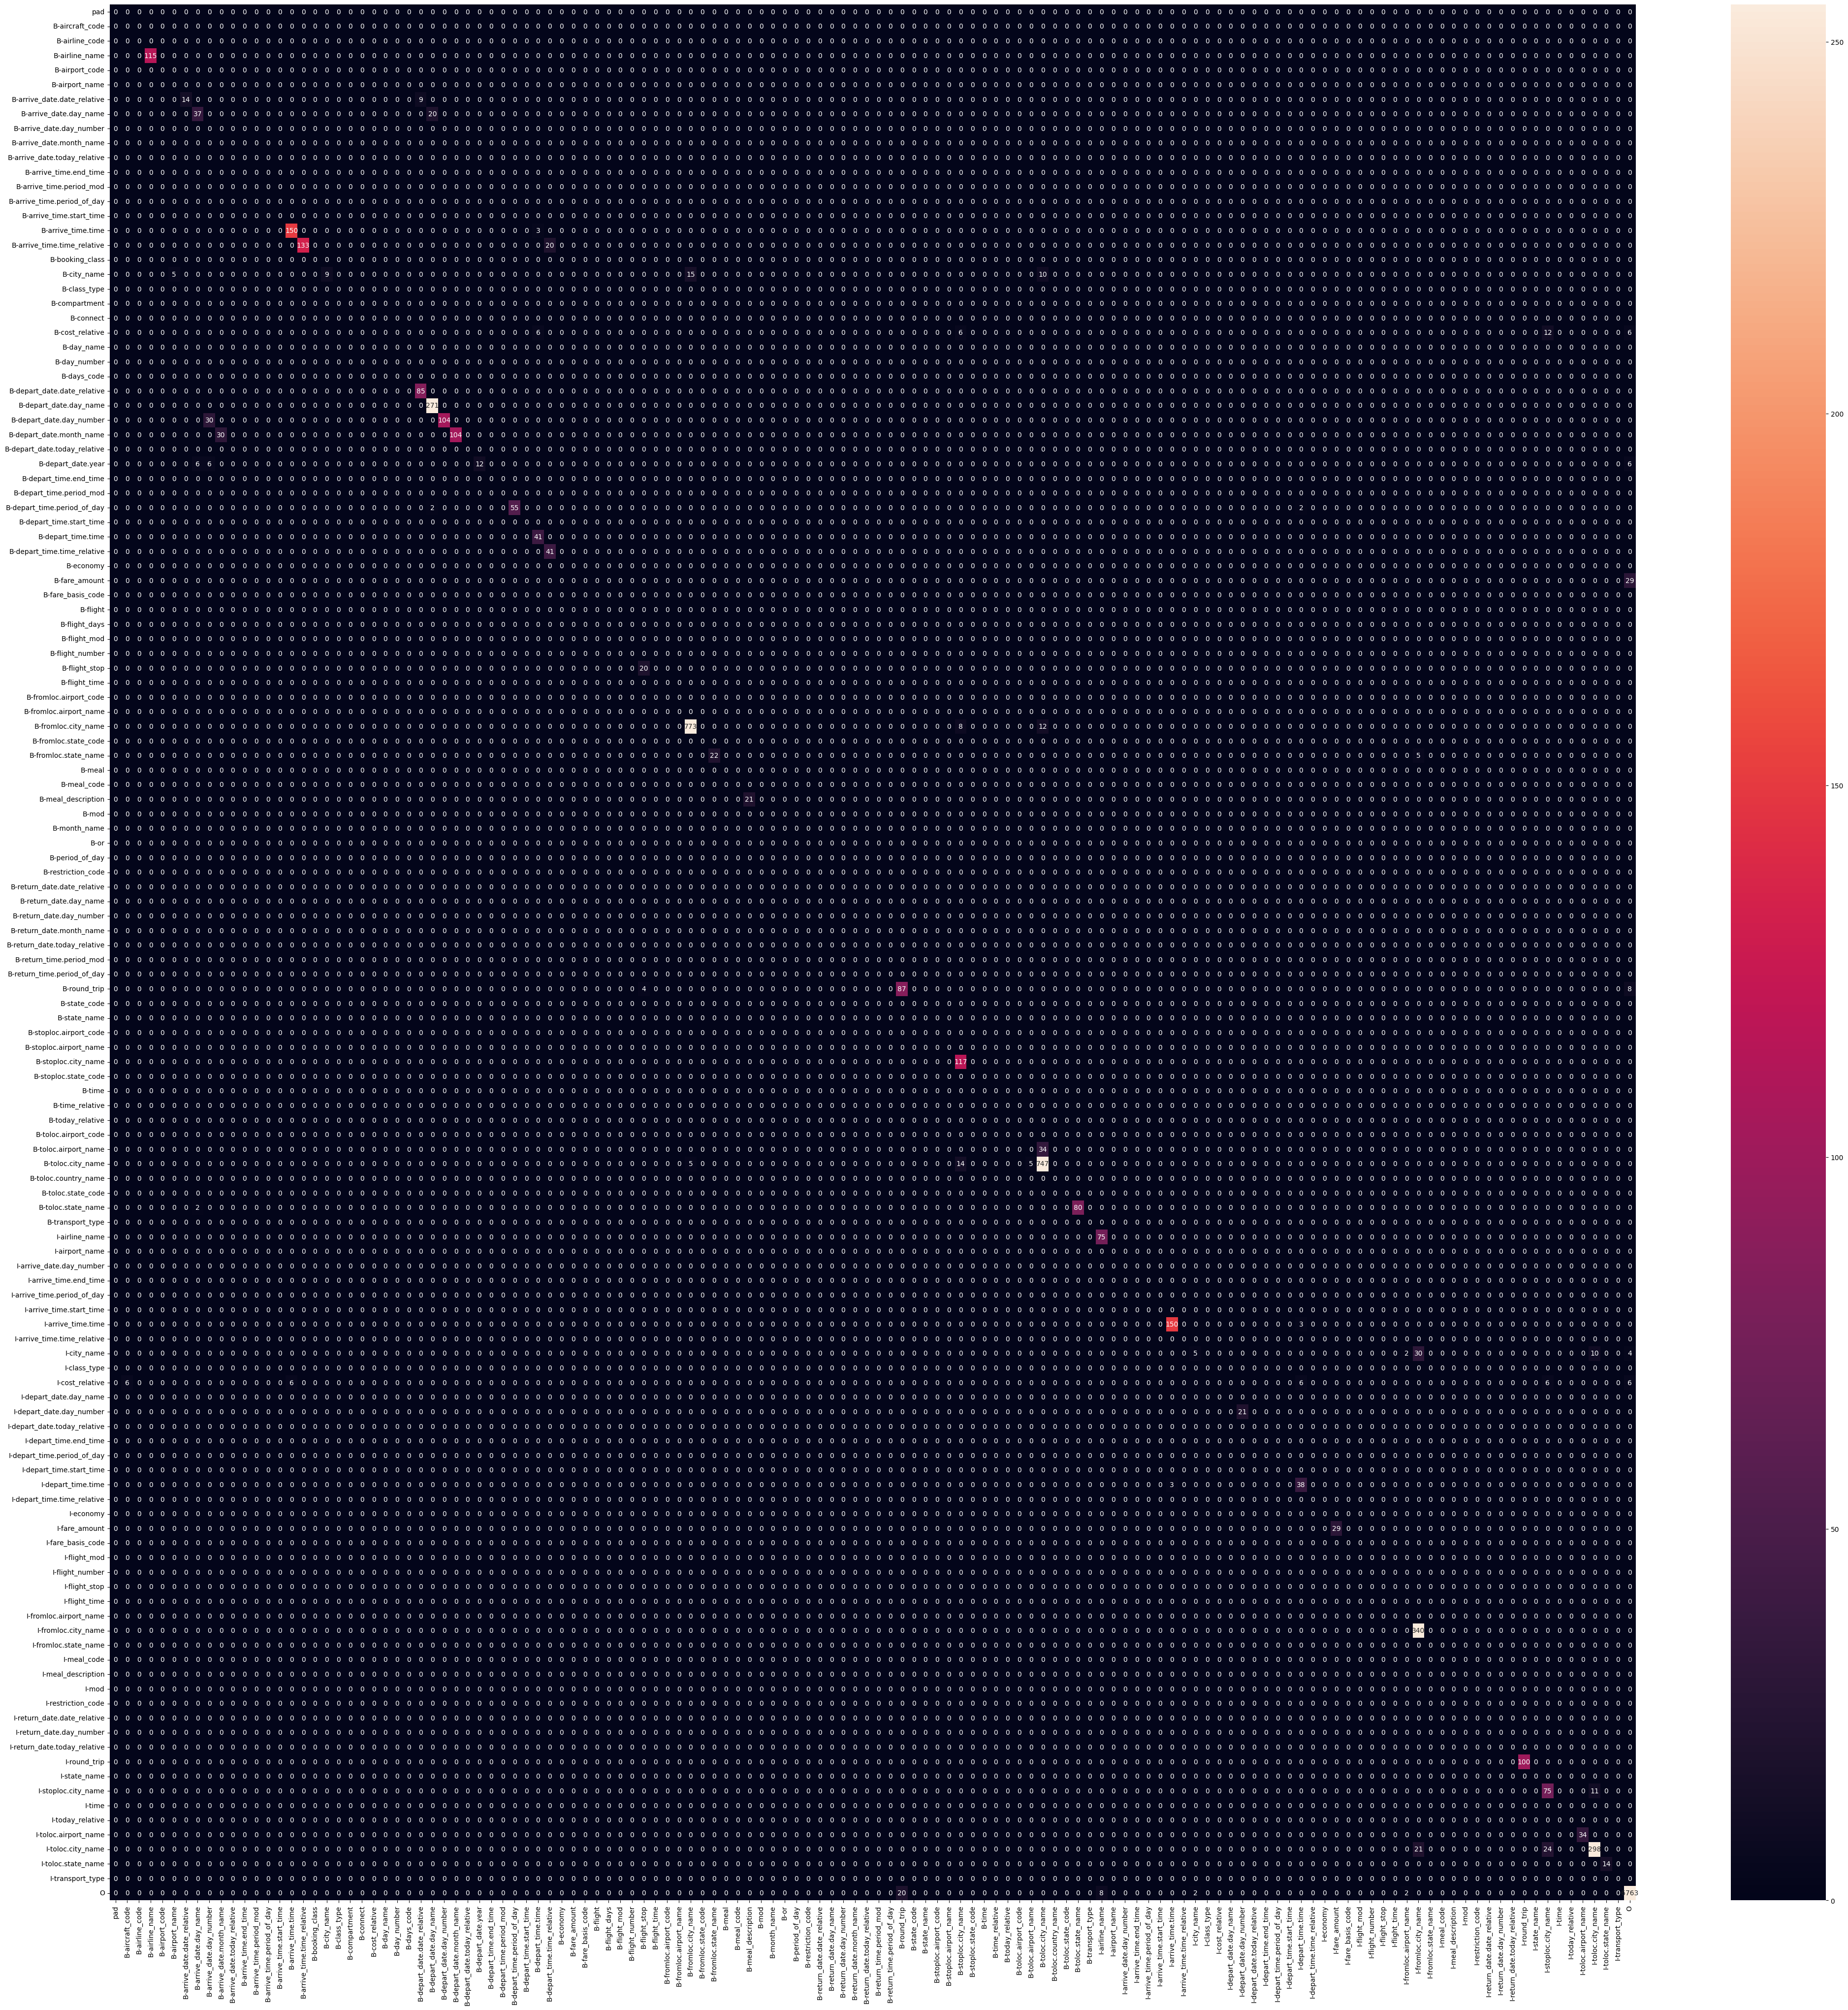

In [74]:
plot_confusion_matrix_slot(atis_total_cm_slot, lang_atis, path=os.path.join("cm", "cm-baseline-atis-slot.png"))

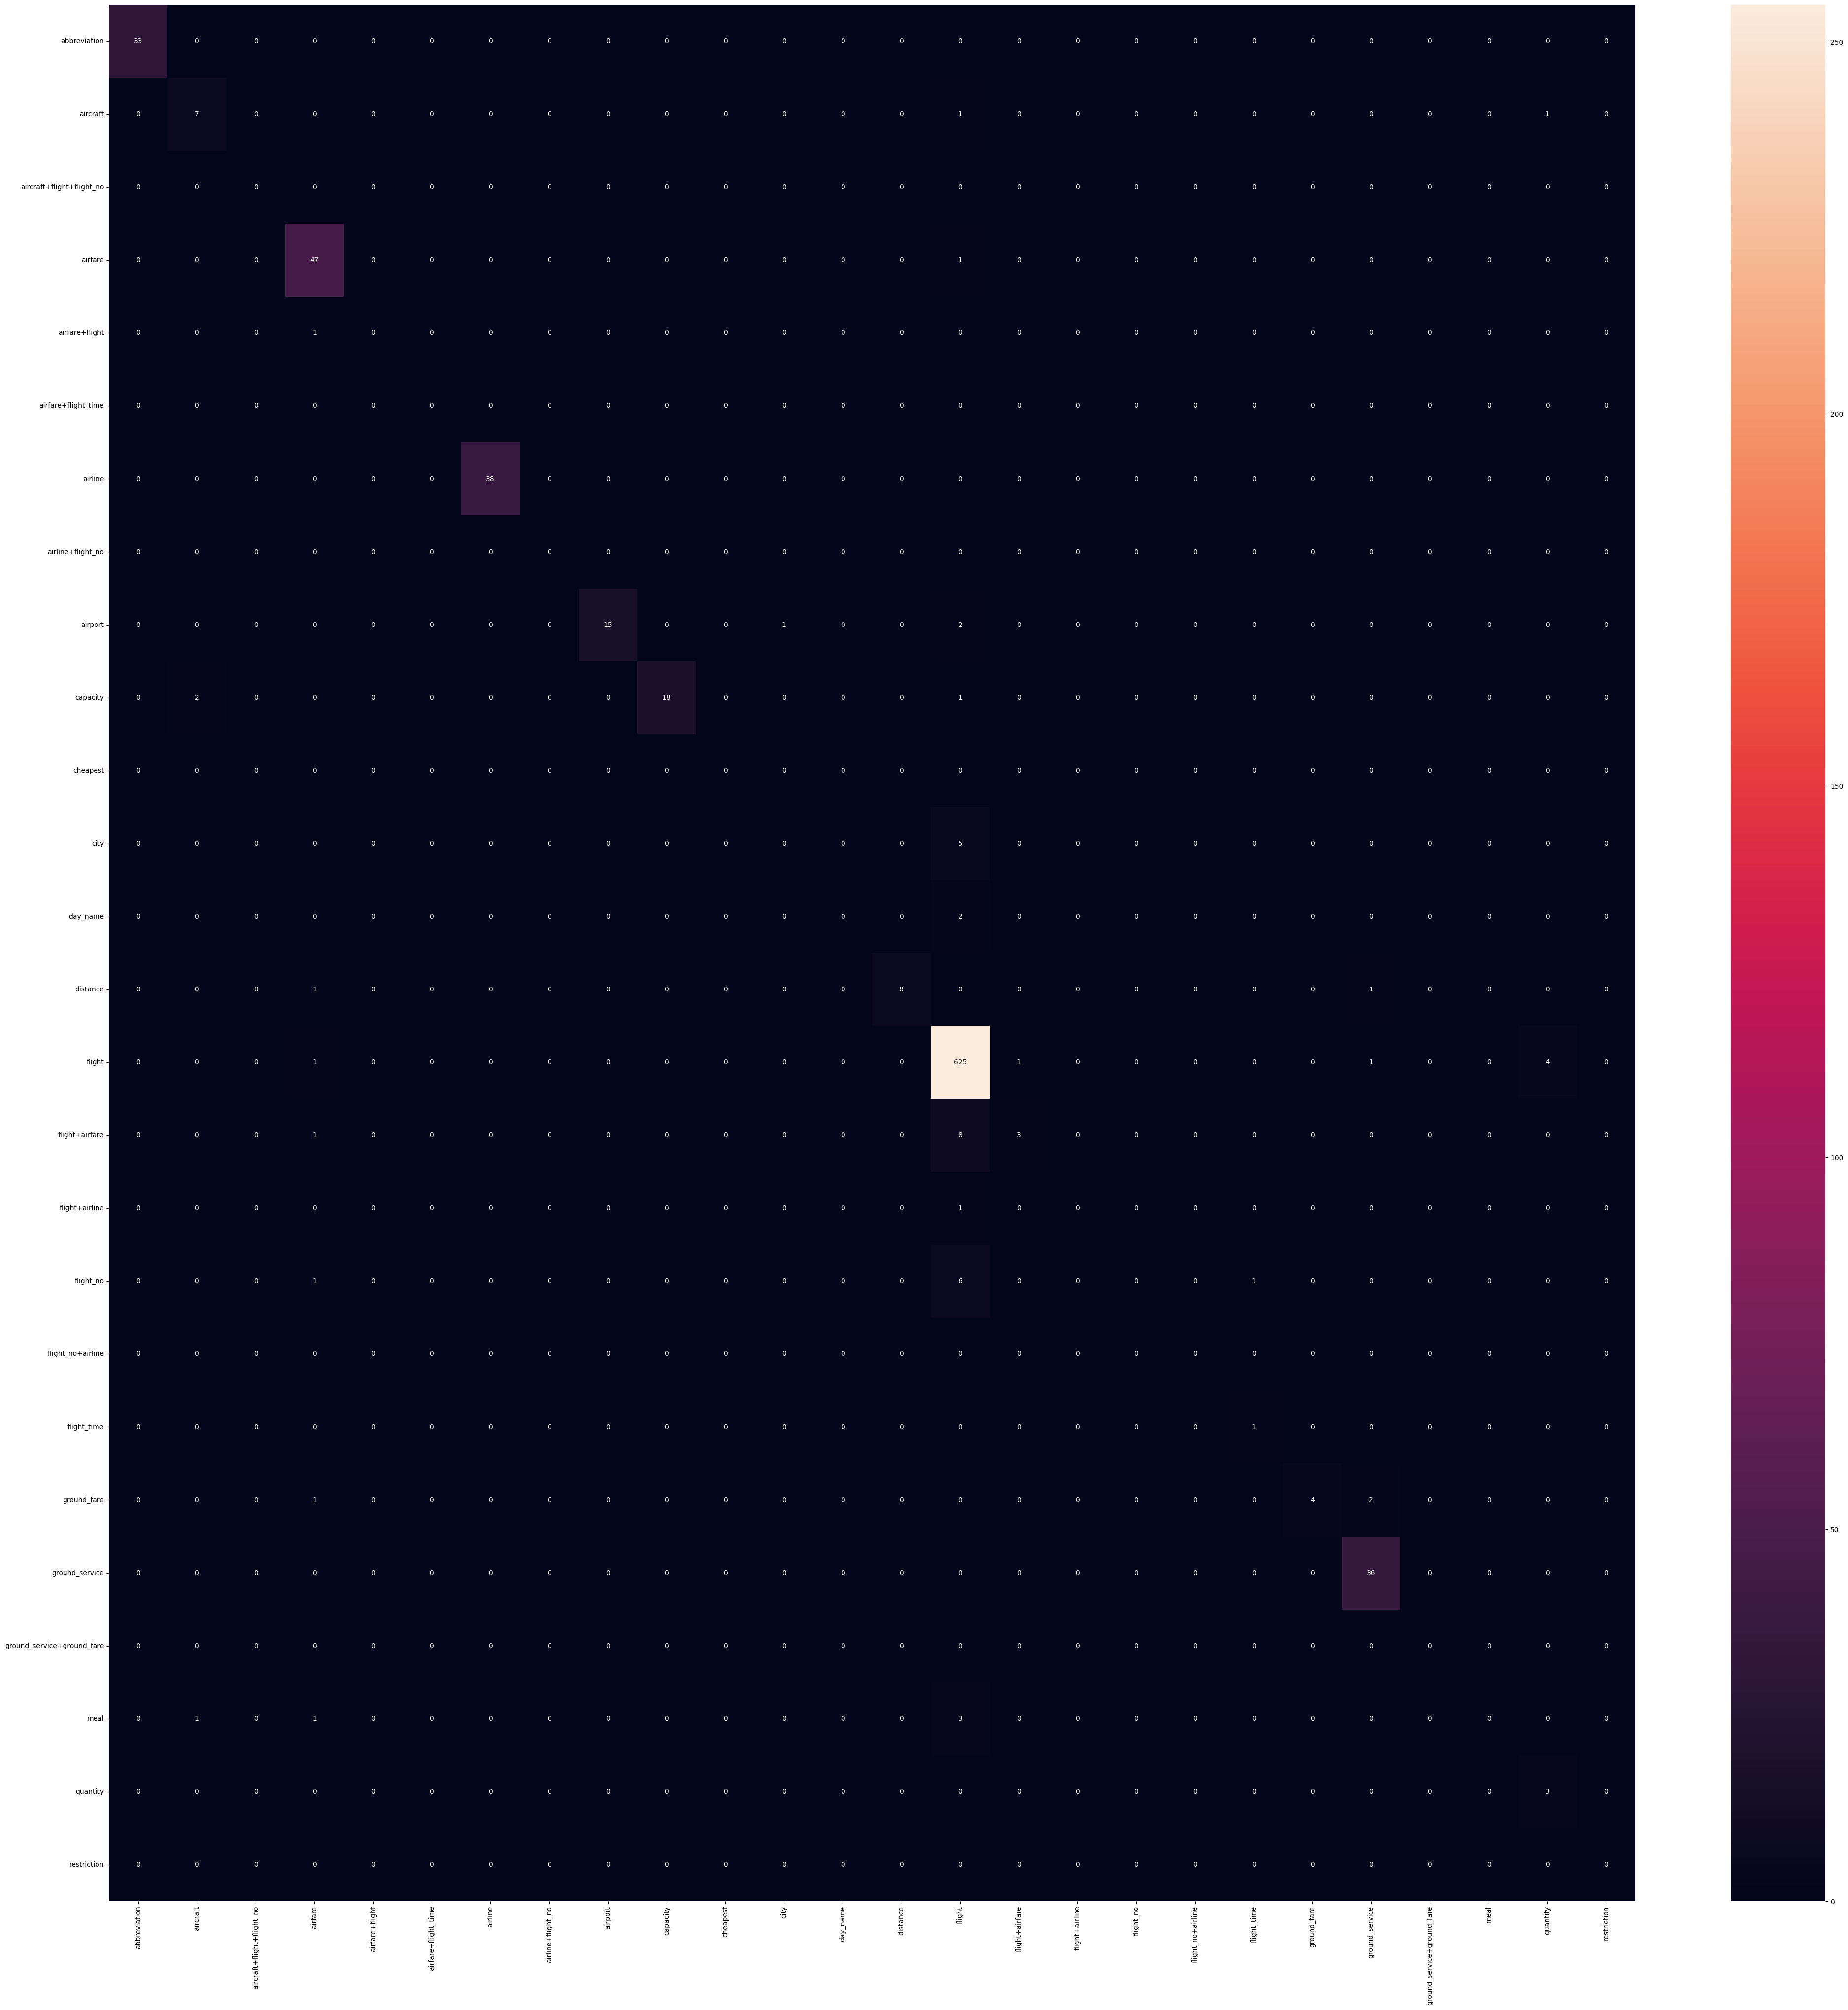

In [75]:
plot_confusion_matrix_intent(atis_total_cm_intent, lang_atis, path=os.path.join("cm", "cm-baseline-atis-intent.png"))

In [70]:
print_summary_slot(average_task_results(atis_total_slot_test))

,p,r,f,s
flight_days,1.0,1.0,1.0,10.0
economy,1.0,1.0,1.0,6.0
fromloc.state_code,1.0,1.0,1.0,23.0
state_code,1.0,1.0,1.0,1.0
toloc.state_code,1.0,1.0,1.0,18.0
...,...,...,...,...
booking_class,1.0,0.0,0.0,1.0
meal_code,0.6,0.0,0.0,1.0
state_name,1.0,0.0,0.0,9.0
flight,1.0,0.0,0.0,1.0


In [71]:
print_summary_intent(average_task_results(atis_total_intent_test))

,precision,recall,f1-score,support
abbreviation,0.977451,0.987879,0.982069,33.0
airline,0.965109,0.994737,0.979415,38.0
flight,0.952150,0.988291,0.969879,632.0
ground_service,0.891770,0.994444,0.939958,36.0
airfare,0.892726,0.970833,0.930095,48.0
weighted avg,0.920890,0.936618,0.922876,893.0
airport,0.986667,0.844444,0.908268,18.0
capacity,0.950505,0.847619,0.893820,21.0
distance,1.000000,0.760000,0.856725,10.0
aircraft,0.743550,0.777778,0.744649,9.0


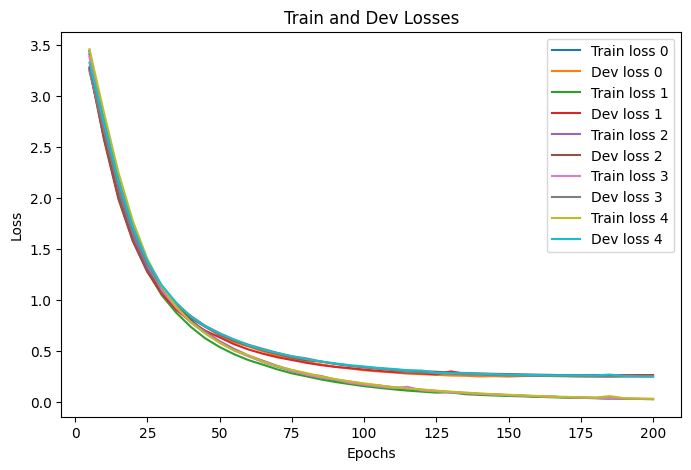

In [87]:
print_losses(atis_total_sampled_epochs, atis_total_losses_train, atis_total_losses_dev, path=os.path.join("loss", "loss-baseline-atis.png"))

In [77]:
print_scores(snips_total_slot_test, snips_total_intent_test)

Slot F1 0.803 +- 0.012
Intent Acc 0.961 +- 0.005


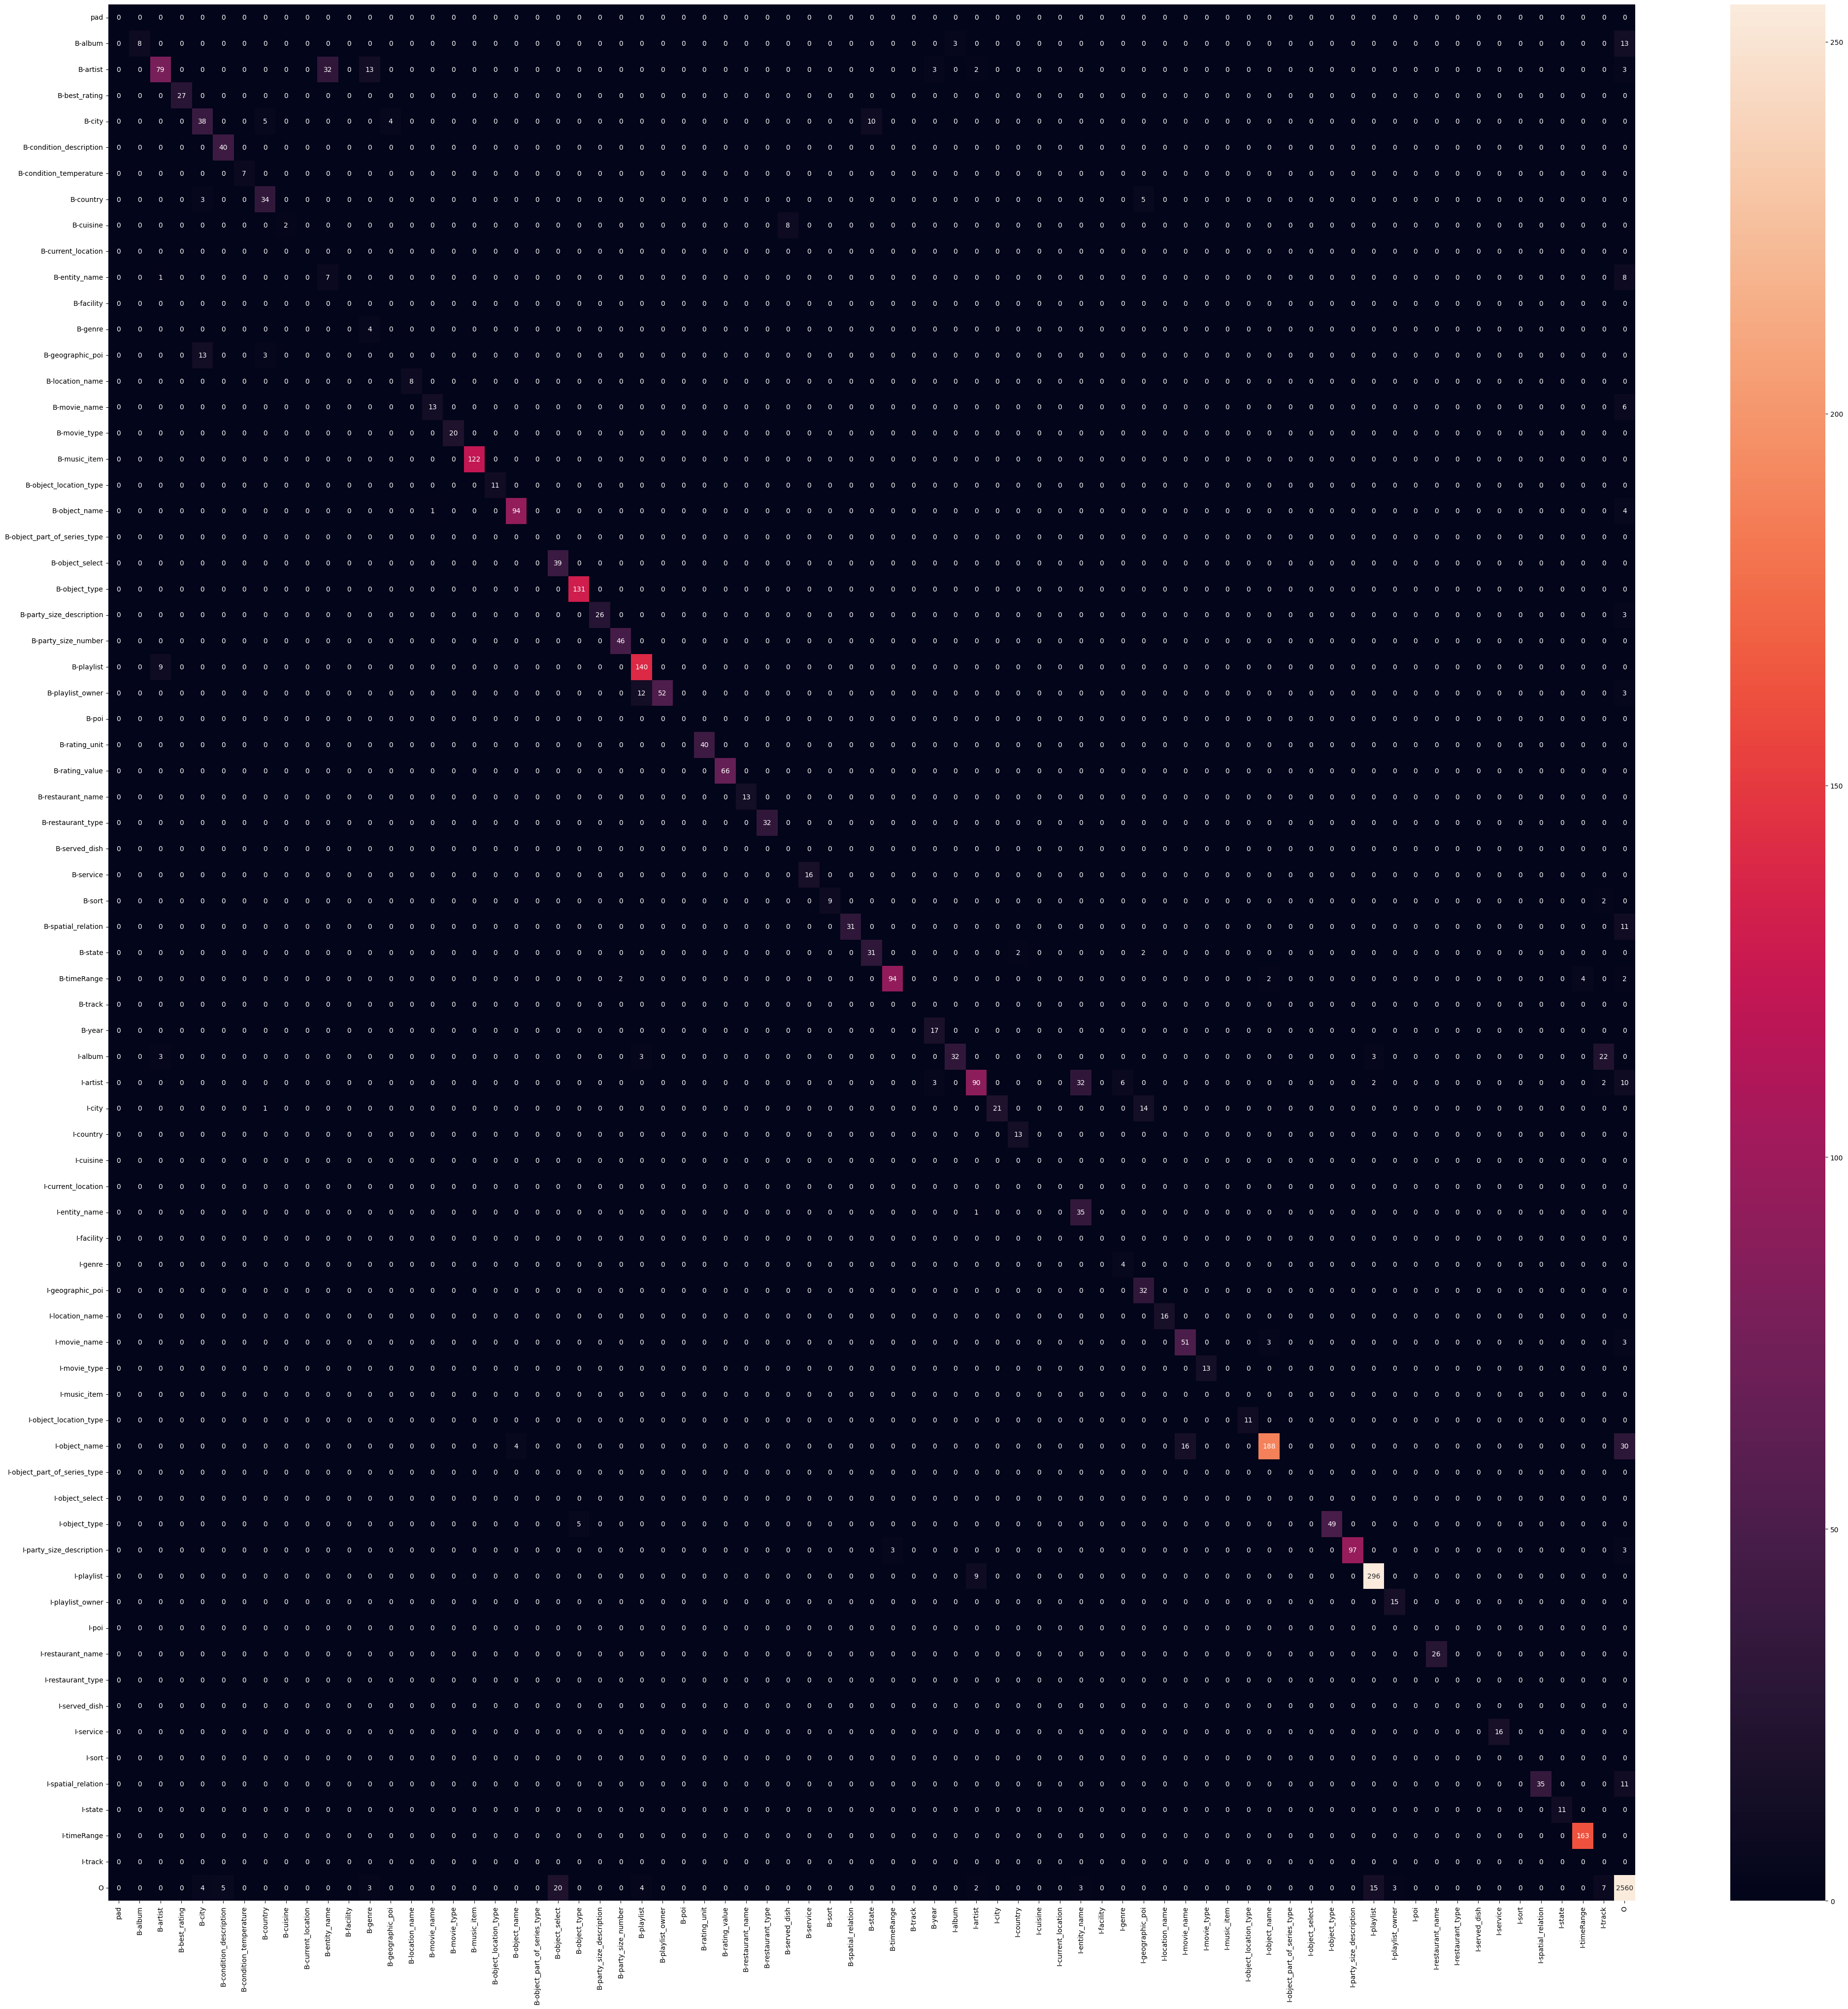

In [78]:
plot_confusion_matrix_slot(snips_total_cm_slot, lang_snips, path=os.path.join("cm", "cm-baseline-snips-slot.png"))

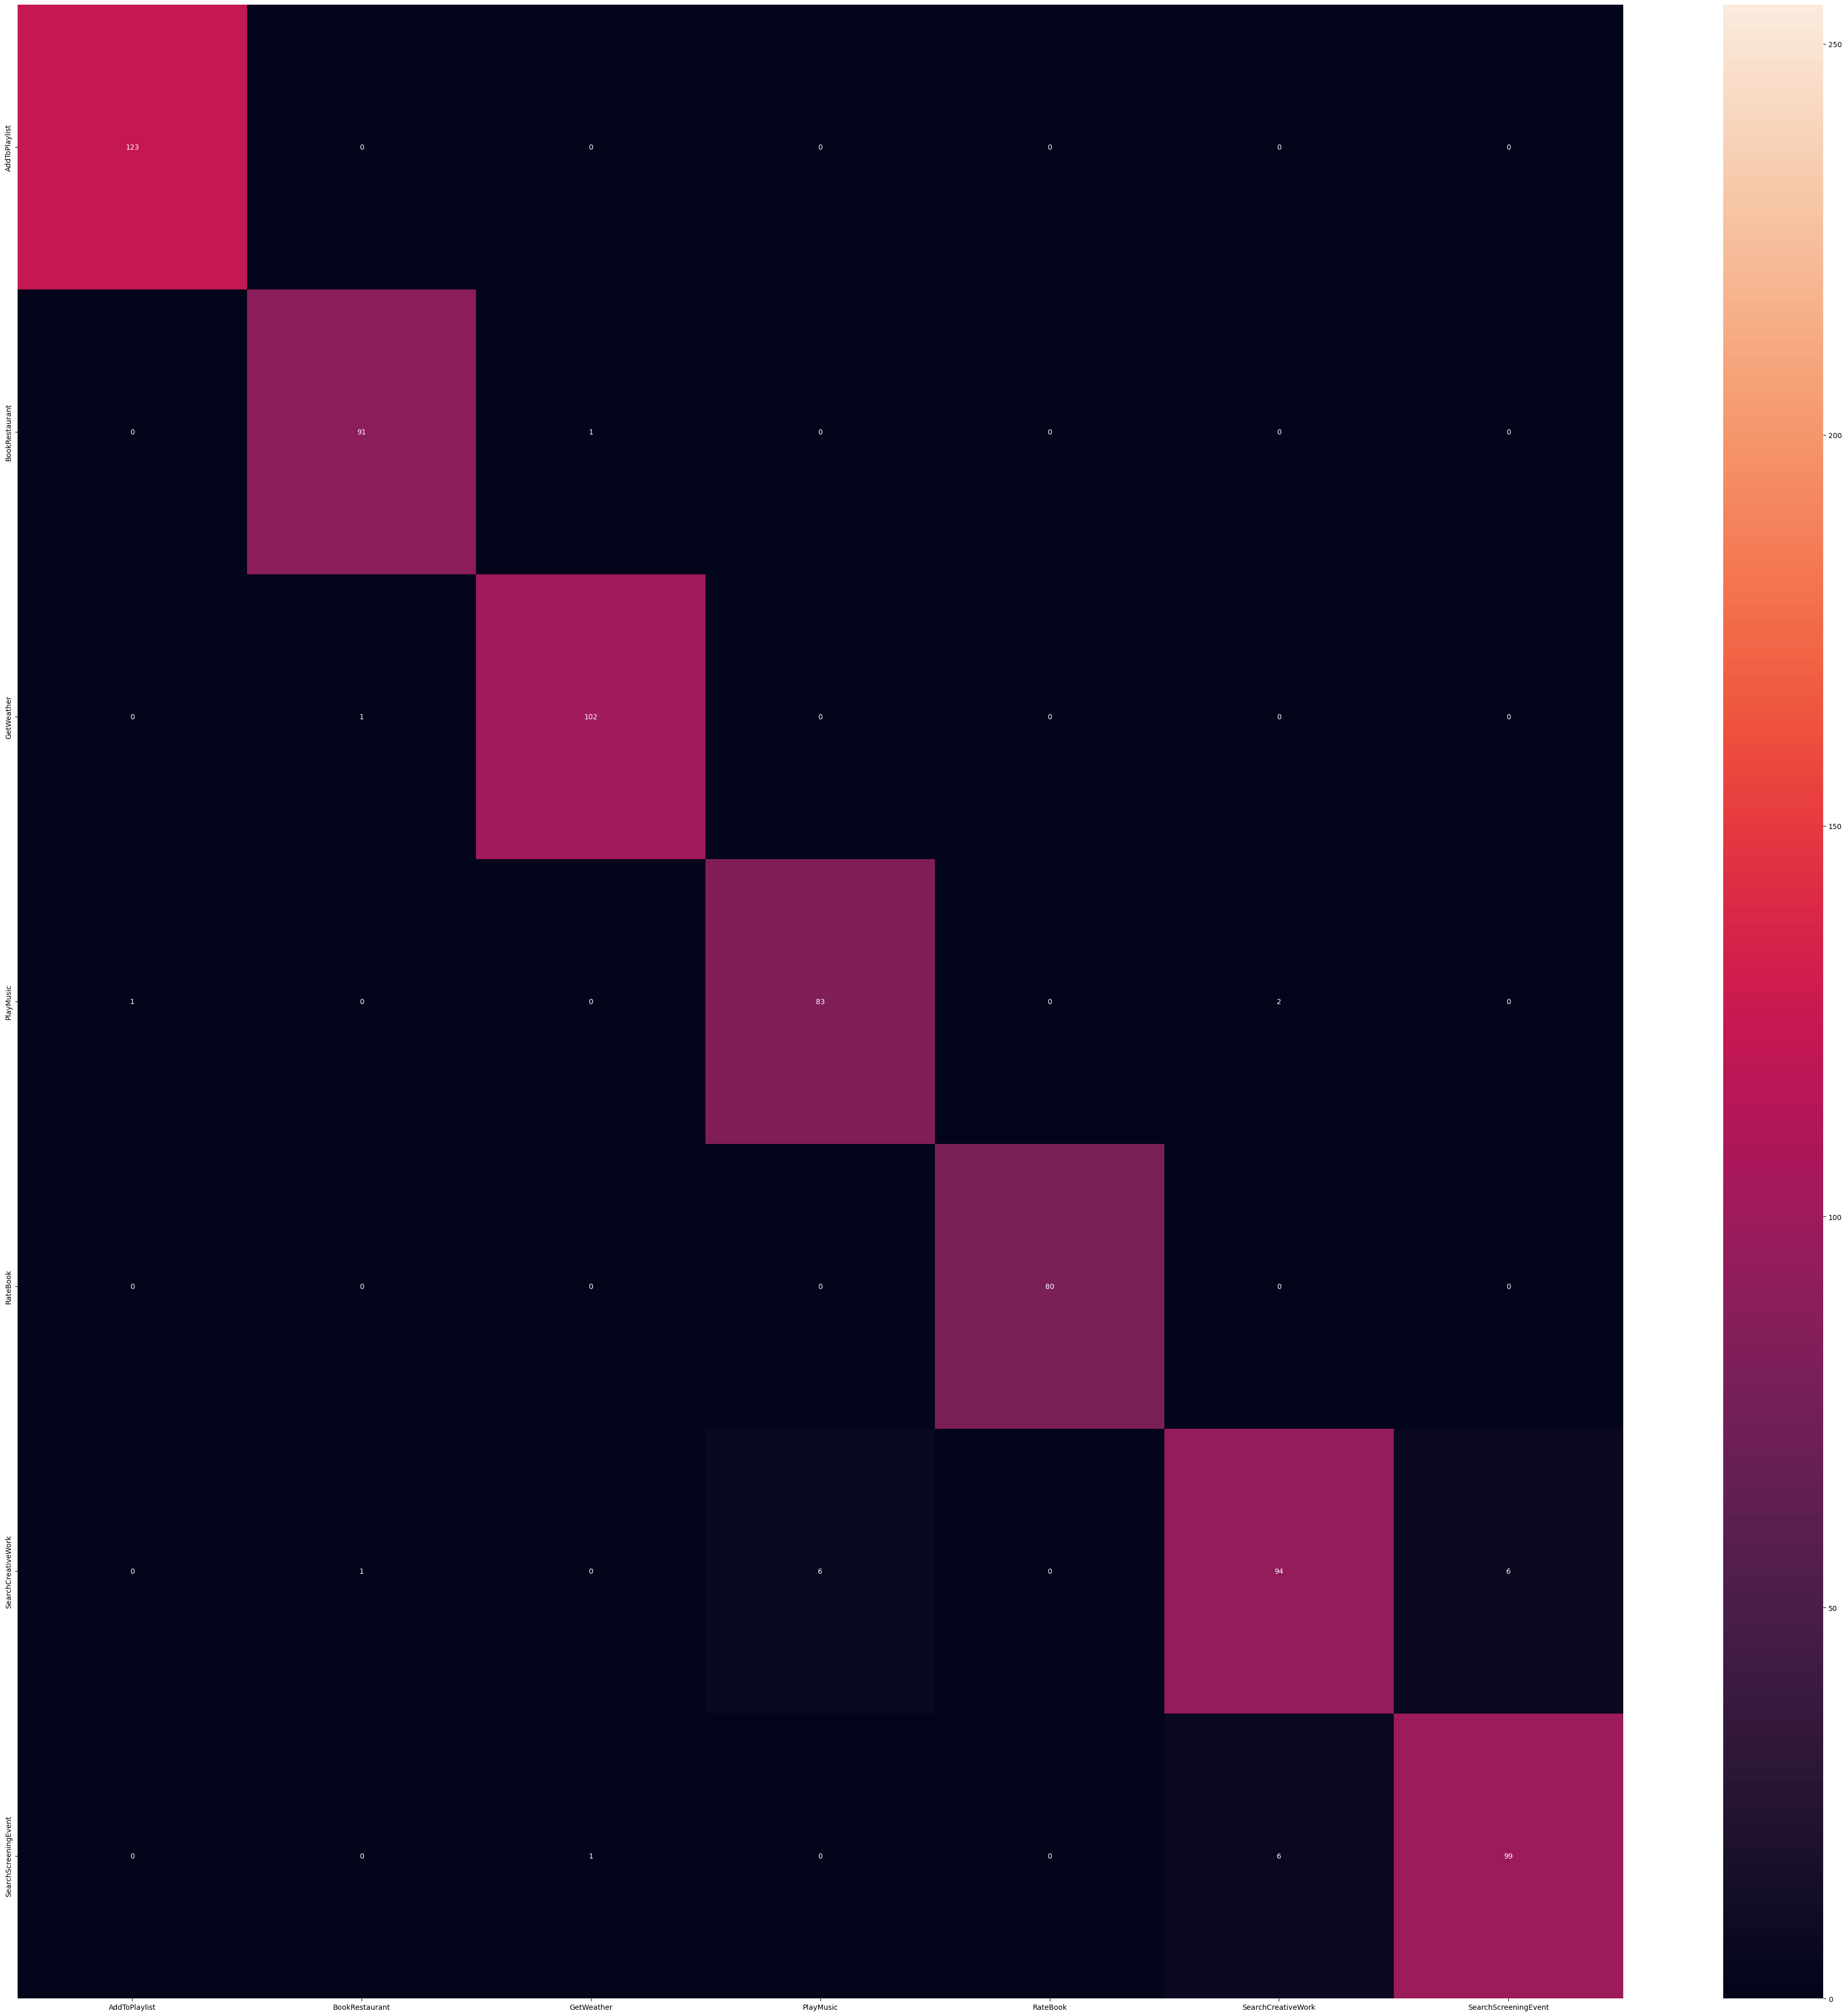

In [79]:
plot_confusion_matrix_intent(snips_total_cm_intent, lang_snips, path=os.path.join("cm", "cm-baseline-snips-intent.png"))

In [80]:
print_summary_slot(average_task_results(snips_total_slot_test))

,p,r,f,s
best_rating,1.000000,1.000000,1.000000,43.0
rating_unit,1.000000,1.000000,1.000000,40.0
facility,1.000000,1.000000,1.000000,3.0
movie_type,0.983333,1.000000,0.991304,33.0
condition_temperature,1.000000,0.965217,0.982222,23.0
rating_value,0.973015,0.985000,0.978911,80.0
music_item,0.957143,0.986538,0.971581,104.0
current_location,1.000000,0.928571,0.962963,14.0
restaurant_type,0.974845,0.947692,0.961020,65.0
service,0.951333,0.966667,0.958844,24.0


In [81]:
print_summary_intent(average_task_results(snips_total_intent_test))

,precision,recall,f1-score,support
RateBook,0.997531,1.000000,0.998758,80.0
AddToPlaylist,0.991987,0.993548,0.992745,124.0
GetWeather,0.979007,0.984615,0.981762,104.0
BookRestaurant,0.972516,0.984783,0.978493,92.0
macro avg,0.961331,0.962552,0.961603,700.0
weighted avg,0.961380,0.961143,0.960925,700.0
PlayMusic,0.927474,0.967442,0.946705,86.0
SearchScreeningEvent,0.939012,0.928972,0.933456,107.0
SearchCreativeWork,0.921793,0.878505,0.899303,107.0


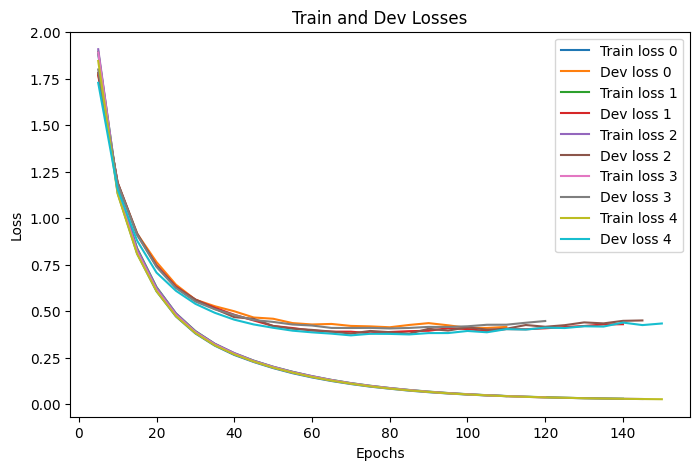

In [86]:
print_losses(snips_total_sampled_epochs, snips_total_losses_train, snips_total_losses_dev, path=os.path.join("loss", "loss-baseline-snips.png"))

## Model A - Bi-LSTM
The Model A is an evolution of the baseline model, by using bilinear LSTM. In this case the architecture is slightly more complex:
- increased hidden and embedding size
- 2-layer bilinear LSTM
- added LayerNorm for the two linear heads
- higher learning rate
- added class weights to the cross entropy loss to handle unbalanced data

In [80]:
# good second model atis

hid_size = 400
emb_size = 600

lr = 0.001 # learning rate
clip = 5 # Clip the gradient

out_slot = len(lang_atis.slot2id)
out_int = len(lang_atis.intent2id)
vocab_len = len(lang_atis.word2id)

model = ModelIAS(hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=PAD_TOKEN, n_layer=2, bidirectional=True).to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

results_test, intent_test, losses_train, losses_dev, sampled_epochs = train_model(
    model,
    lang_atis,
    criterion_intents,
    criterion_slots,
    optimizer,
    train_loader_atis,
    dev_loader_atis,
    test_loader_atis
)

 27%|██▋       | 54/199 [01:49<04:54,  2.03s/it]


Slot F1:  0.9482971589906476
Intent Accuracy: 0.9641657334826428


In [100]:
atis_slot_weight = torch.zeros(len(lang_atis.slot2id)).to(device)
for slot, slot_id in lang_atis.slot2id.items():
    atis_slot_weight[slot_id] = 1 - (slot_counter_atis[slot]/len(slot_flat_list_atis))

atis_intent_weight = torch.zeros(len(lang_atis.intent2id)).to(device)
for intent, intent_id in lang_atis.intent2id.items():
    atis_intent_weight[intent_id] = 1 - (intent_counter_atis[intent]/len(intent_list_atis))

In [104]:
# cross reweight atis

hid_size = 400
emb_size = 600

lr = 0.001 # learning rate
clip = 5 # Clip the gradient

out_slot = len(lang_atis.slot2id)
out_int = len(lang_atis.intent2id)
vocab_len = len(lang_atis.word2id)

model = ModelIAS(hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=PAD_TOKEN, n_layer=2, bidirectional=True).to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN, weight=atis_slot_weight)
criterion_intents = nn.CrossEntropyLoss(weight=atis_intent_weight) # Because we do not have the pad token

results_test, intent_test, losses_train, losses_dev, sampled_epochs = train_model(
    model,
    lang_atis,
    criterion_intents,
    criterion_slots,
    optimizer,
    train_loader_atis,
    dev_loader_atis,
    test_loader_atis
)

 30%|██▉       | 59/199 [01:57<04:39,  2.00s/it]


Slot F1:  0.951150442477876
Intent Accuracy: 0.9686450167973124


In [19]:
hid_size = 400
emb_size = 600

lr = 0.001 # learning rate
clip = 5 # Clip the gradient

out_slot = len(lang_snips.slot2id)
out_int = len(lang_snips.intent2id)
vocab_len = len(lang_snips.word2id)

model = ModelIAS(hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=PAD_TOKEN, n_layer=2, bidirectional=True).to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

results_test, intent_test, losses_train, losses_dev, sampled_epochs = train_model(
    model,
    lang_snips,
    criterion_intents,
    criterion_slots,
    optimizer,
    train_loader_snips,
    dev_loader_snips,
    test_loader_snips
)

 25%|██▍       | 49/199 [03:27<10:36,  4.24s/it]

Slot F1:  0.906674051509277
Intent Accuracy: 0.9757142857142858


In [124]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ModelA(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0, bidirectional=False):
        super(ModelA, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=bidirectional)    
        self.slot_out = nn.Linear(hid_size*2 if bidirectional else hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)

        self.dropout = nn.Dropout(0.1)
        self.norm_slot = nn.LayerNorm(hid_size*2 if bidirectional else hid_size)
        self.norm_intent = nn.LayerNorm(hid_size)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        
        slots = self.norm_slot(utt_encoded)
        # slots = self.dropout(slots)
        slots = self.slot_out(slots)

        intent = self.norm_intent(last_hidden)
        # intent = self.dropout(intent)
        intent = self.intent_out(intent)
        
        # Slot size: seq_len, batch size, classes 
        slots = slots.permute(1, 2, 0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

In [126]:
# good second model atis

hid_size = 400
emb_size = 600

lr = 0.001 # learning rate
clip = 5 # Clip the gradient

out_slot = len(lang_atis.slot2id)
out_int = len(lang_atis.intent2id)
vocab_len = len(lang_atis.word2id)

model = ModelA(hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=PAD_TOKEN, n_layer=2, bidirectional=True).to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN, weight=atis_slot_weight)
criterion_intents = nn.CrossEntropyLoss(weight=atis_intent_weight) # Because we do not have the pad token

results_test, intent_test, losses_train, losses_dev, sampled_epochs = train_model(
    model,
    lang_atis,
    criterion_intents,
    criterion_slots,
    optimizer,
    train_loader_atis,
    dev_loader_atis,
    test_loader_atis
)

 20%|█▉        | 39/199 [01:21<05:35,  2.09s/it]


Slot F1:  0.9485190409026798
Intent Accuracy: 0.9664053751399776


In [ ]:
(
    atis_total_slot_test,
    atis_total_intent_test,
    atis_total_losses_train,
    atis_total_losses_dev,
    atis_total_sampled_epochs,
    atis_total_cm_slot,
    atis_total_cm_intent
) = repeat_training_process_baseline(lang_atis, train_loader_atis, dev_loader_atis, test_loader_atis)

 ![](https://huggingface.co/front/assets/huggingface_logo-noborder.svg)
# Hugging Face
Hugging Face is a library that allows you to used large pretrained models in an easy way. This means that you do not need to implement an architeture and train it from scratch. Hugging Face is also a community where people share trained models and code.
<br/><br/>
In Hugging Face there are many different models (https://huggingface.co/models) that you can import and each of them has its own input and output shapes. However, Transformer-based models are usually composed of two parts: 
- **Tokenizer**
- **Architecture/Pretrained model**

The **tokenizers** used by Transformer-based models are different from those we saw in the lab. While for instance Spacy's tokenizer is rule-based and splits the text looking at the punctuation, the goal of Transformer tokenizers is to reduce the vocabulary length by spliting words into subwords. To do this, several algorithms have been proposed. If you are interested in this topic you can find a thoroughly explanation here: https://huggingface.co/docs/transformers/tokenizer_summary  

In [51]:
# BERT model script from: huggingface.co
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer("I saw a man with a telescope", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
last_hidden_states.shape

torch.Size([1, 9, 768])

# Exercise
Experiment with the neural network **ModelIAS**. Try to change hyperparameters, layers and architercure. 